In [458]:
"""
Step 1. Load data
"""
from utils.trial import load_trial

# Edit these values
SUBJECTS_DIR = "subjects"
SUBJECT_NAME = "ncbc_s15"
TRIAL_NAME = "TM_p9"
RESULTS_FILE = "results.json"
# ================================

trial = load_trial(SUBJECTS_DIR, SUBJECT_NAME, TRIAL_NAME)
SUBJECT_WEIGHT = trial.subject_weight

sensors = trial.load_sensors()
treadmill_unaligned = trial.load_treadmill()

In [460]:
"""
Step 2. Use the alignment tool to find signal offsets.
Only uncomment one side at a time.
"""
from utils.viz import visually_align_signal

# Uncomment below to align left ankle and left force signals
SENSOR_SIGNAL = sensors.left_df['accel_filtered']
TREADMILL_SIGNAL = treadmill_unaligned.left_df['vgrf']

# Uncomment below to align right ankle and right force signals
#SENSOR_SIGNAL = sensors.right_df['accel_filtered']
#TREADMILL_SIGNAL = treadmill_unaligned.right_df['vgrf'] 

visually_align_signal(SENSOR_SIGNAL, TREADMILL_SIGNAL)
#sensors.left_df.head()

In [461]:
"""
Step 3. Align sensor and treadmill signals.

Use the above cell to visually determine offsets for the treadmill signals.
After you do that, update the values of LEFT_VGRF_OFFSET and RIGHT_VGRF_OFFSET.
"""

import pandas as pd
from utils.treadmill import TreadmillData

LEFT_VGRF_OFFSET = 431    # INPUT VALUE FROM STEP 2!
RIGHT_VGRF_OFFSET = 301    # INPUT VALUE FROM STEP 2!

def apply_offset(treadmill_df: pd.DataFrame, offset: int):
    """
    Applies an offset to treadmill_df
    """
    if offset < 0:
        out_df = treadmill_df.iloc[-offset:]
    elif offset > 0:
        padding = pd.DataFrame({'time': [0]*offset, 'vgrf': [0]*offset})
        out_df = pd.concat([padding, treadmill_df])
    else:
        out_df = treadmill_df
    return out_df.reset_index(drop=True)

left_df = apply_offset(treadmill_unaligned.left_df, LEFT_VGRF_OFFSET)
right_df = apply_offset(treadmill_unaligned.right_df, RIGHT_VGRF_OFFSET)

treadmill = TreadmillData(left_df, right_df)

[690     0.912751
691     0.904433
692     0.896004
693     0.885477
694     0.871848
          ...   
1730    0.965383
1731    0.981352
1732    0.997072
1733    1.011700
1734    1.024113
Name: accel_filtered, Length: 1045, dtype: float64, 1735    1.033177
1736    1.038127
1737    1.038831
1738    1.035765
1739    1.029764
          ...   
1865    0.982237
1866    1.005275
1867    1.022447
1868    1.032133
1869    1.034111
Name: accel_filtered, Length: 135, dtype: float64, 1870    1.029346
1871    1.019674
1872    1.007393
1873    0.994767
1874    0.983512
          ...   
1989    1.042243
1990    1.000360
1991    0.971098
1992    0.952996
1993    0.941187
Name: accel_filtered, Length: 124, dtype: float64, 1994    0.930780
1995    0.919180
1996    0.906646
1997    0.895385
1998    0.888018
          ...   
2113    0.919812
2114    0.939116
2115    0.947989
2116    0.943136
2117    0.924928
Name: accel_filtered, Length: 124, dtype: float64, 2118    0.897924
2119    0.869976
2120    0.85

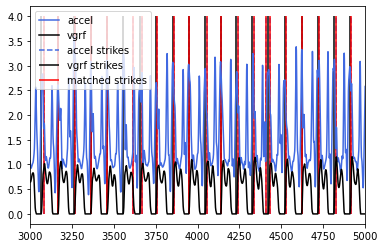

In [462]:
"""
Step 3. Extract strike indices and stances from the left.
"""
import matplotlib.pyplot as plt
from operator import itemgetter
from utils.stance import parse_and_match_stances
from utils.config import PipelineConfig

# You can uncomment and change the config to see how it affects the results.
#  See all parameters in utils/config.py

config = PipelineConfig(
    accel_peak_params={
        'height': 1.0,
        'prominence': 0.5,
        'width': 5.0,
        'distance': 10
    },
    jerk_peak_params={
        'height': 0.0,
        'prominence': 0.1
    },
    jerk_window_size=50,
    stance_matching_time_threshold=50,
    accel_filters=[],
    vgrf_filters=[],
    min_stance_size=80,
    max_stance_size=140
)

left_strikes, left_stances, debug = parse_and_match_stances(
    sensors.left_df['accel_filtered'],
    sensors.left_df['accel'],
    sensors.waist_df['accel_filtered'],
    treadmill.left_df['vgrf'],
    config # <--- Uncomment to use your own config
)


# Plot accel
plt.plot(sensors.left_df['accel_filtered'], color='royalblue',label='accel')
plt.vlines(debug['accel_strikes'], 0, 4, color='royalblue', linestyle='--', label='accel strikes')

# Plot vgrf
plt.plot(treadmill.left_df['vgrf'], color='black', label='vgrf')
plt.vlines(debug['vgrf_strikes'], 0, 4, color='black', label='vgrf strikes')

# Plot matched strikes
plt.vlines(list(map(itemgetter(0), left_strikes)), 0, 4, color='red', label='matched strikes')

# show plot
#plt.xlim(2000,3000)
#plt.xlim(16000,17500)
plt.xlim(3000,5000)
#plt.xlim(1000, 2500)
plt.legend()
plt.show()




# NOTE: Dropping filters and increasing stance_matching_time_threshold from 5 -> 10
# will cause more strikes to be matched.

[607    1.018151
608    1.013149
609    1.005695
610    0.994620
611    0.979122
         ...   
711    1.784466
712    2.418565
713    3.012803
714    3.414700
715    3.509692
Name: accel_filtered, Length: 109, dtype: float64, 716     3.266336
717     2.751323
718     2.106406
719     1.497589
720     1.059017
          ...   
1784    1.211780
1785    1.175862
1786    1.133736
1787    1.091698
1788    1.054155
Name: accel_filtered, Length: 1073, dtype: float64, 1789    1.023257
1790    0.999204
1791    0.981002
1792    0.967311
1793    0.957075
          ...   
1915    1.287406
1916    1.308692
1917    1.291144
1918    1.234618
1919    1.149604
Name: accel_filtered, Length: 131, dtype: float64, 1920    1.054186
1921    0.968189
1922    0.907006
1923    0.877630
1924    0.878098
          ...   
2021    1.067145
2022    1.068299
2023    1.066619
2024    1.065026
2025    1.067563
Name: accel_filtered, Length: 106, dtype: float64, 2026    1.078129
2027    1.098806
2028    1.128451
2029  

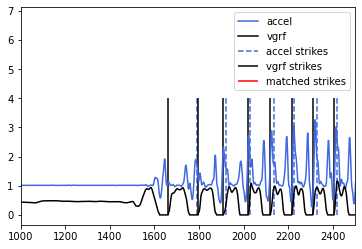

In [463]:
"""
Step 4. Extract strike indices and stances from the right.
"""

import matplotlib.pyplot as plt
from operator import itemgetter
from utils.stance import parse_and_match_stances
from utils.config import PipelineConfig

# You can uncomment and change the config to see how it affects the results.
#  See all parameters in utils/config.py

config = PipelineConfig(
    accel_peak_params={
        'height': 1.0,
        'prominence': 0.5,
        'width': 5.0,
        'distance': 10
    },
    jerk_peak_params={
        'height': 0.0,
        'prominence': 0.1
    },
    jerk_window_size=50,
    stance_matching_time_threshold=50,
    accel_filters=[],
    vgrf_filters=[],
    min_stance_size=80,
    max_stance_size=140
)


right_strikes, right_stances, debug = parse_and_match_stances(
    sensors.right_df['accel_filtered'],
    sensors.right_df['accel'],
    sensors.waist_df['accel_filtered'],
    treadmill.right_df['vgrf'],
    # config # <--- Uncomment to use your own config
)

# Plot accel
plt.plot(sensors.right_df['accel_filtered'], color='royalblue',label='accel')
plt.vlines(debug['accel_strikes'], 0, 4, color='royalblue', linestyle='--', label='accel strikes')

#plt.plot(sensors.waist_df['accel_filtered'], color='pink', label=)
# Plot vgrf
plt.plot(treadmill.right_df['vgrf'], color='black', label='vgrf')
plt.vlines(debug['vgrf_strikes'], 0, 4, color='black', label='vgrf strikes')

# Plot matched strikes
plt.vlines(list(map(itemgetter(0), right_strikes)), 0, 4, color='red', label='matched strikes')

# show plot
plt.xlim(1000, 2500)
plt.legend()
plt.show()

# NOTE: This side looks like it has good peak detection, but the strikes between the treadmill and sensors
# are not matching up.

In [464]:
"""
Step 5. Merge both sides and run through the model.
"""
import csv
import os
from utils.predict import predict_stance
from utils.output import make_peak_results, make_stance_results

RESULTS_DIR = 'results/ncbc_s15/TM_p9' # Edit me!

REF_PEAKS_FILE = os.path.join(RESULTS_DIR, 'reference_peaks.xlsx')
PRED_PEAKS_FILE = os.path.join(RESULTS_DIR, 'pred_peaks.xlsx')
REF_STANCES_FILE_LEFT = os.path.join(RESULTS_DIR, 'reference_waveforms_L.xlsx')
REF_STANCES_FILE_RIGHT = os.path.join(RESULTS_DIR, 'reference_waveforms_R.xlsx')
PRED_STANCES_FILE_LEFT = os.path.join(RESULTS_DIR, 'pred_waveforms_L.xlsx')
PRED_STANCES_FILE_RIGHT = os.path.join(RESULTS_DIR, 'pred_waveforms_R.xlsx')

if os.path.exists(RESULTS_DIR):
    print(f"A directory called {RESULTS_DIR}/ already exists")
else:
    os.makedirs(RESULTS_DIR)

    left_accel_stances = list(map(itemgetter(0), left_stances)) 
    left_vgrf_stances = list(map(itemgetter(1), left_stances))
    right_accel_stances = list(map(itemgetter(0), right_stances))
    right_vgrf_stances = list(map(itemgetter(1), right_stances))

    # Use the MLP model to predict vGRF stances from accel stances
    left_vgrf_pred_stances = list(map(predict_stance, left_accel_stances))
    right_vgrf_pred_stances = list(map(predict_stance, right_accel_stances))

    # Create reference and predicted peak results
    ref_peak_results = make_peak_results(left_vgrf_stances, right_vgrf_stances)
    ref_peak_results.to_excel(REF_PEAKS_FILE, index=False)

    pred_peak_results = make_peak_results(left_vgrf_pred_stances, right_vgrf_pred_stances)
    pred_peak_results.to_excel(PRED_PEAKS_FILE, index=False)

    # Create reference and predicted stance (waveform) results
    left_vgrf_stances = pd.DataFrame(left_vgrf_stances)
    left_vgrf_stances_T = left_vgrf_stances.T
    
    right_vgrf_stances = pd.DataFrame(right_vgrf_stances)
    right_vgrf_stances_T = right_vgrf_stances.T
    
    left_vgrf_results = pd.DataFrame(left_vgrf_stances_T)
    left_vgrf_results.columns = [f"step_{i+1}" for i in range(left_vgrf_results.shape[1])]
    left_vgrf_results.to_excel(REF_STANCES_FILE_LEFT, index=False)
    right_vgrf_results = pd.DataFrame(right_vgrf_stances_T)
    right_vgrf_results.columns = [f"step_{i+1}" for i in range(right_vgrf_results.shape[1])]
    right_vgrf_results.to_excel(REF_STANCES_FILE_RIGHT, index=False)

    left_vgrf_pred_stances = pd.DataFrame(left_vgrf_pred_stances)
    left_vgrf_pred_stances_T = left_vgrf_pred_stances.T
    right_vgrf_pred_stances = pd.DataFrame(right_vgrf_pred_stances)
    right_vgrf_pred_stances_T = right_vgrf_pred_stances.T
    
    left_pred_waveform_results = pd.DataFrame(left_vgrf_pred_stances_T)
    left_pred_waveform_results.columns = [f"step_{i+1}" for i in range(left_pred_waveform_results.shape[1])]
    left_pred_waveform_results.to_excel(PRED_STANCES_FILE_LEFT, index=False)
    right_pred_waveform_results = pd.DataFrame(right_vgrf_pred_stances_T)
    right_pred_waveform_results.columns = [f"step_{i+1}" for i in range(right_pred_waveform_results.shape[1])]
    right_pred_waveform_results.to_excel(PRED_STANCES_FILE_RIGHT, index=False)

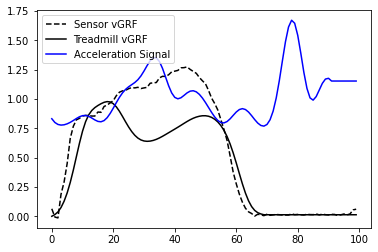

In [468]:
import numpy as np

random_index = np.random.randint(0, len(left_vgrf_pred_stances))

plt.plot(left_vgrf_pred_stances.T[random_index], color = "black", linestyle = "--", label = "Sensor vGRF")
plt.plot(left_vgrf_stances.T[random_index], color = "black",  label = "Treadmill vGRF")
plt.plot(left_accel_stances[random_index], color = "blue",  label = "Acceleration Signal")
plt.legend()
plt.show()


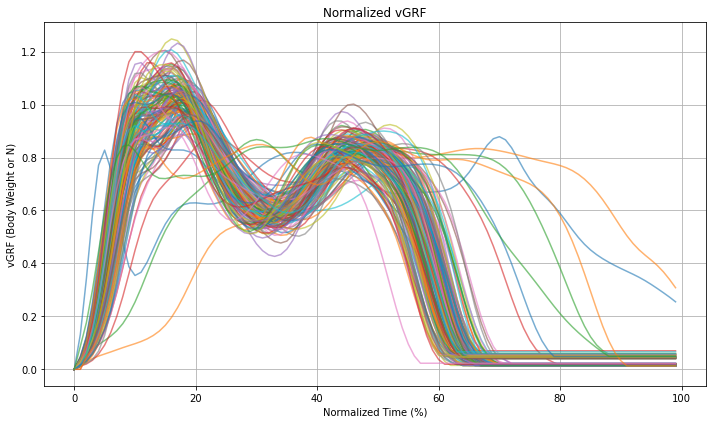

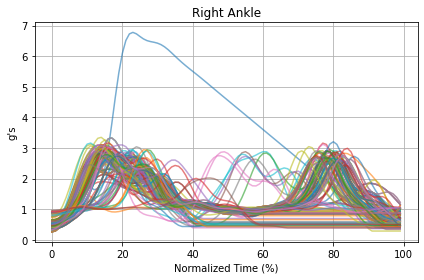

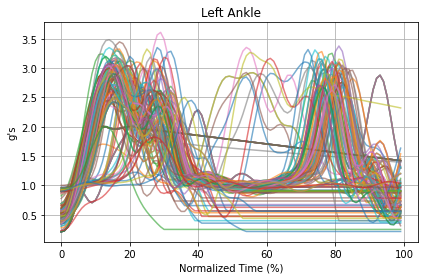

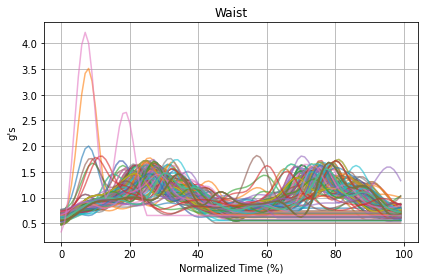

In [469]:
from utils.stance import StanceAnalyzer
import matplotlib.pyplot as plt

analyzer = StanceAnalyzer() 
vgrf = treadmill.left_df['vgrf']  
start_idx, stances = analyzer.extract_treadmill_stances(vgrf)  

#vgrf
plt.figure(figsize=(10, 6))
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Normalized vGRF")
plt.xlabel("Normalized Time (%)")
plt.ylabel("vGRF (Body Weight or N)")
plt.grid(True)
plt.tight_layout()
plt.show()


r_ankle = sensors.right_df['accel_filtered']
start_idx, stances = analyzer.extract_treadmill_stances(r_ankle)  
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Right Ankle")
plt.xlabel("Normalized Time (%)")
plt.ylabel("g's")
plt.grid(True)
plt.tight_layout()
plt.show()

l_ankle = sensors.left_df['accel_filtered']
start_idx, stances = analyzer.extract_treadmill_stances(l_ankle)  
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Left Ankle")
plt.xlabel("Normalized Time (%)")
plt.ylabel("g's")
plt.grid(True)
plt.tight_layout()
plt.show()

l_waist = sensors.waist_df['accel_filtered']
start_idx, stances = analyzer.extract_treadmill_stances(l_waist)  
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Waist")
plt.xlabel("Normalized Time (%)")
plt.ylabel("g's")
plt.grid(True)
plt.tight_layout()
plt.show()